# Formatting function development
> A place to test and develop formatting functions for the passing of objects between Python, Zemax, and any other programs or file formats

In [1]:
import numpy as np
from astropy.io import fits
import imageio
from scipy.ndimage import zoom
import os
os.chdir("..")
print(os.getcwd())
import matplotlib.pyplot as plt

/Users/louis/Projects/Toliman/Modelling


To Do:


## Current Scripts

In [50]:
def pupil_from_fits(file_name, offset=0, output_size=0):
    """
    Takes in the fits file and returns a complex array of the pupil
    """
    # Create a fits object from astropy
    fits_file = fits.open(file_name)[0].data
    array = np.array(fits_file)
    
    if output_size != 0:
        ratio = output_size/array.shape[0]
        scaled_array = zoom(array, ratio)

        # Some values seem to get changed in the process, this is an ad-hoc fix
        scaled_array[scaled_array >= np.pi] = np.pi
        scaled_array[scaled_array < 0] = 0
        
        array = scaled_array

    # Calculate needed values
    gridsize = array.shape[0] - 2*offset
    c = gridsize//2
    
    # Create value arrays
    Xs = np.linspace(-c, c-1, num=gridsize)
    X, Y = np.meshgrid(Xs, Xs)
    r = np.hypot(X, Y)
    
    # Create pupil
    pupil = np.exp(1j*array)
    
    # Zero outer regions
    pupil[r >= (gridsize//2) + offset] = np.complex(0,0)
        
    return pupil

In [51]:
# input_size = pupil.shape[0]
# ratio = output_size/input_size
# # pupil_sized = zoom(pupil, ratio)

pupil = pupil_from_fits("files/pupil_new_2k.fits", output_size=2048)
# pupil = pupil_from_fits("files/pupil_new_2k.fits", output_size=0)

(2048, 2048)


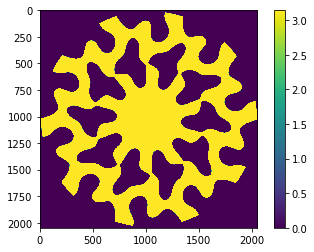

In [54]:
plt.imshow(np.angle(pupil))
plt.colorbar()
print(pupil.shape)

In [3]:
def zemax_to_array(path_to_file):
    with open(path_to_file,'rb') as f:
        contents = f.read()
        
    contents = contents.decode("utf-16").split("\n")
    data_raw = [line.strip() for line in contents]
    
    metadata = []
    data = []
    
    for line in data_raw[:20]:
        if line != '':
            metadata.append(line)
            
    for line in data_raw[21:-1]:
        line = line.split("\t  ")
        line_formatted = [float(l) for l in line if l != '']
        data.append(line_formatted)
        
    return np.asarray(data), metadata

In [4]:
def create_sag_file(file_name, pupil, aperture, unit, target_wl):
    """
    Creates a sag file formatted for Zemax
    file_name: Name for the file
    Pupil: complex array
    unit: unit of measurement (mm, cm, m, in)
    aperture: telescope aperture in units of 'unit'
    target_wl: ideal wavelength in units of 'unit'
    """
    unit_dict = {"mm": 0, "cm": 1, "in": 2, "m": 3}
    phase_range = 2*np.pi
    
    nx = pupil.shape[0]
    ny = pupil.shape[1]
    delx = aperture/nx
    dely = aperture/ny
    unitflag  = unit_dict[unit]
    xdec = 0
    ydec = 0
    
    with open("{}_sag.DAT".format(file_name), 'w') as f:
        f.write("{} {} {} {} {} {} {}\n".format(nx, ny, delx, dely, unitflag, xdec, ydec))
        
        for i in range(nx):
            for j in range(ny):
                sag_ratio = np.angle(pupil[i][j])/phase_range
                sag_val = sag_ratio*target_wl
                if sag_val < 1e-6:
                    sag_val = 0
                    
                f.write("{} {} {} {} {}\n".format(sag_val, 0, 0, 0, 0))

In [5]:
def create_phase_file(file_name, pupil, aperture, unit):
    """
    Creates a sag file formatted for Zemax
    file_name: Name for the file
    Pupil: complex array
    unit: unit of measurement (mm, cm, m, in)
    aperture: telescope aperture in units of 'unit'
    """
    unit_dict = {"mm": 0, "cm": 1, "in": 2, "m": 3}
    
    nx = pupil.shape[0]
    ny = pupil.shape[1]
    delx = aperture/nx
    dely = aperture/ny
    unitflag  = unit_dict[unit]
    xdec = 0
    ydec = 0
    
    with open("{}_phase.DAT".format(file_name), 'w') as f:
        f.write("{} {} {} {} {} {} {}\n".format(nx, ny, delx, dely, unitflag, xdec, ydec))
        
        for i in range(nx):
            for j in range(ny):
                phase_val = np.angle(pupil[i][j])
                f.write("{} {} {} {} {}\n".format(phase_val, 0, 0, 0, 0))  

In [6]:
def create_gif(arrays, name, directory="files/gifs"):
    """
    Creates a gif out of a series of greyscale arrays
    
    Inputs:
        arrays, array: A list or array of (greyscale) arrays to turned into a gif
        name, String: Name of the gif to be created
        directory, string: location to place the gifs object in
        
    Returns:
        None
        
    Notes:
        Negative values are not handled properly! (can use np.abs() to fix for small values)
    """
#     formatted_arrays = format_arrays(arrays)
    imageio.mimsave("{}/{}.gif".format(directory, name), formatted_arrays)

In [7]:
def format_arrays(arrays):
    """
    Formats (scales) the data in a series of arrays to be turned into gif series
    Primary use is to suspress warning output when creating a gif with imagieio
    """
    arrays_out = []
    for array in arrays:
        scaled_array = 255 * (array / np.max(array))
        formatted = scaled_array.astype(np.uint8)
        arrays_out.append(formatted)
        
    return arrays_out

## Development area

## Redundant scripts

In [8]:
# Slower non vectorsed version
def pupil_from_fits(file_name, offset=0):
    """
    Takes in the fits file and returns a complex array of the pupil
    
    Vectorise
    """
    fits_file = fits.open(file_name)[0].data
    
    gridsize = fits_file.shape[0] - 2*offset
    c = gridsize//2
    pupil = np.zeros((gridsize-offset,gridsize-offset), dtype=complex)

    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c 
            r = np.hypot(x, y)
            if r >= (gridsize//2) + offset:
                pupil[i][j] = np.complex(0,0)
            else:
                pupil[i][j] = np.exp(1j*fits_file[i][j])
        
    return pupil